# Airbender

In [1]:
# conda install pandas
# conda install matplotlib
# conda install -c derickl coremltools
import pandas as pd
import numpy as np
import glob

In [2]:
acc_names = ["acc" + str(x) for x in range(1, 51)]
acc_names.insert(0, "Gesture")
acc_names.insert(0, "Participant")
data_names = ["acc_x","acc_y","acc_z","gyr_x","gyr_y","gyr_z"]

all_files = glob.glob("./data_resampled_50/*.csv")

class_names = ["Gesture", "Participant"]
classes = range(0,12)

data = []

for file in all_files:
    df = pd.read_csv(file, sep=";", names=acc_names).dropna()
    data.append(df)

In [3]:
data[0].shape

(600, 52)

In [4]:
data[0].head()

,Participant,Gesture,acc1,acc2,acc3,acc4,acc5,acc6,acc7,acc8,...,acc41,acc42,acc43,acc44,acc45,acc46,acc47,acc48,acc49,acc50
0,bobs1,0,-0.059865,-0.069397,-0.037380,-0.012355,0.001150,-0.018286,-0.033317,-0.029248,...,-0.000221,-0.008255,-0.006038,-0.001672,-0.007495,0.000963,-0.011782,-0.013143,-0.117768,0.001530
1,bobs1,1,-0.013313,-0.005151,-0.008571,-0.010444,-0.022486,-0.010592,0.019433,0.029569,...,0.010821,0.007335,0.004965,-0.000504,-0.001840,-0.004827,-0.004163,-0.001818,0.005122,0.002972
2,bobs1,2,0.019373,-0.019052,0.001603,-0.002592,0.001626,-0.020513,-0.066254,-0.029167,...,0.002932,0.003382,-0.002632,-0.004869,-0.017792,-0.001028,-0.012888,0.005177,-0.011054,-0.347110
3,bobs1,3,-0.005394,0.006832,0.057838,0.399088,0.422796,0.232613,-0.116611,-0.279797,...,-0.059534,0.084551,-0.005322,-0.057228,-0.054312,-0.039944,-0.052329,-0.049464,-0.030054,0.149331
4,bobs1,4,0.016960,0.003094,0.006899,0.007311,-0.021284,0.004319,0.051683,0.123159,...,-0.103017,-0.075641,-0.115577,-0.103518,-0.099656,-0.076318,-0.073939,-0.029251,-0.100809,0.037867


In [5]:
import matplotlib.pyplot as plt

### Plot some info about data

In [6]:
data_x = data[0].values[:, ~data[0].columns.isin(class_names)]
plot_data = data_x[13].astype(np.float32, copy=False)

In [7]:
plot_data_rot2 = data[3].loc[data[1]["Gesture"] == 1, :].iloc[5,2:52].values
plot_data_rot2 = plot_data_rot2.astype(np.float32, copy=False)

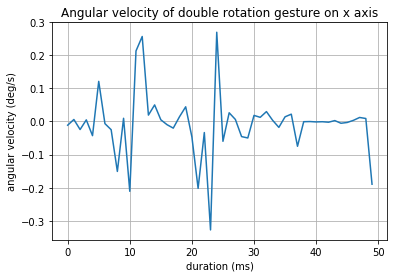

In [8]:
plt.plot(plot_data_rot2)
plt.title('Angular velocity of double rotation gesture on x axis')

plt.ylabel('angular velocity (deg/s)')
plt.xlabel('duration (ms)')

plt.grid(True)
plt.savefig('ang_x_double_rot.png')

## Features

In [9]:
features = pd.DataFrame()

### Time Domain

In [10]:
def get_time_feature(data, func):
    temp_feature = pd.DataFrame()
    count=0
    for frame in data:
        mean_df = pd.DataFrame(frame.iloc[:,2:].apply(func, axis=1), columns=[data_names[count] + "_" + func.__name__])
        temp_feature = pd.concat([temp_feature, mean_df], axis=1, sort=False)
        count+=1
        
    return temp_feature

### FFT

In [11]:
def get_magnitude_band(data, band_width):
    temp_feature = pd.DataFrame()
    def get_band(row, band_width, label):
        fft = np.fft.fft(row)
        magnitude = np.abs(fft)
        return pd.Series(magnitude[1:band_width+1],index=[label + "_" + str(x) for x in range(1,band_width+1)])

    count=0
    for frame in data:
        bands = frame.iloc[:,2:].apply(lambda x:get_band(x, band_width, data_names[count]), axis=1)
        temp_feature = pd.concat([temp_feature, bands], axis=1, sort=False)
        count+=1
    
    return temp_feature

### Combine features

In [12]:
time_mean_feature = get_time_feature(data, np.mean)
time_median_feature = get_time_feature(data, np.median)
band_feature = get_magnitude_band(data, 20)

features = pd.concat([data[0].iloc[:, 0:2], band_feature, time_mean_feature, time_median_feature], axis=1, sort=False)
features.head()

,Participant,Gesture,acc_x_1,acc_x_2,acc_x_3,acc_x_4,acc_x_5,acc_x_6,acc_x_7,acc_x_8,...,acc_z_mean,gyr_x_mean,gyr_y_mean,gyr_z_mean,acc_x_median,acc_y_median,acc_z_median,gyr_x_median,gyr_y_median,gyr_z_median
0,bobs1,0,0.415370,0.141621,0.354000,0.207618,0.144910,0.360604,0.761555,0.424918,...,0.151082,-0.011518,-0.049755,0.058895,-0.003490,-0.003490,-0.022883,-0.003490,-0.011255,0.000365
1,bobs1,1,0.467925,0.364173,0.189730,0.182268,0.520980,0.621774,0.122132,0.606170,...,0.033986,0.011955,-0.029323,-0.006534,0.007433,0.007433,-0.028014,0.007433,-0.012092,0.010112
2,bobs1,2,5.681338,3.779824,4.307861,3.029836,1.065532,0.363462,0.299681,0.641040,...,0.003074,0.158690,-0.002375,-0.014394,0.033878,0.033878,-0.022332,0.033878,-0.035808,-0.102876
3,bobs1,3,7.532442,7.069267,6.129050,5.545816,4.093905,3.846589,4.203696,2.955589,...,-0.027944,0.043671,-0.014728,-0.019624,-0.058381,-0.058381,-0.065149,-0.058381,0.002892,-0.011891
4,bobs1,4,3.825446,0.650613,0.641892,0.170284,1.087604,0.616231,0.813964,0.335768,...,-0.023837,0.063217,-0.029117,-0.001446,0.044398,0.044398,0.023210,0.044398,-0.023691,-0.001094


In [13]:
plot_data = features.iloc[0,2:22]
n = plot_data.size
timestep = 0.02
freq = np.arange(1, 21, 1)
freq

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

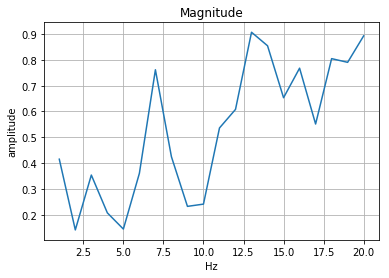

In [14]:
plt.plot(freq, plot_data)
plt.title('Magnitude')

plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.grid(True)

## Feature Reduction

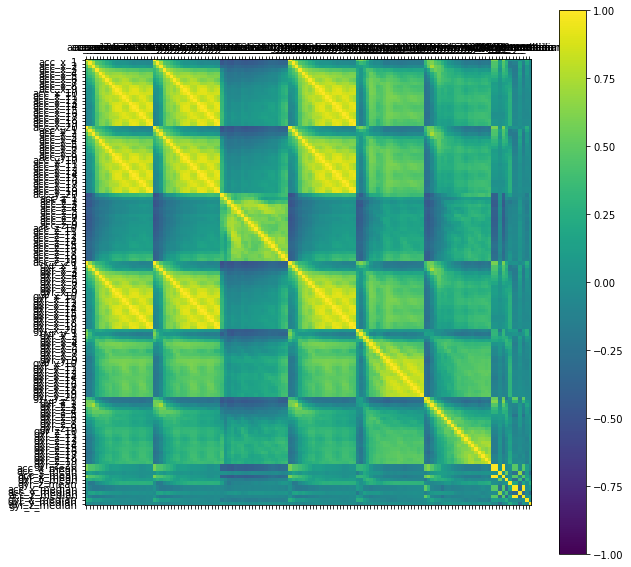

In [15]:
correlations = features.iloc[:, 2:].corr()

# plot correlation matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(features.iloc[:, 2:].columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(features.iloc[:, 2:].columns)
ax.set_yticklabels(features.iloc[:, 2:].columns)
plt.show()

In [16]:
### drop features
# Select upper triangle of correlation matrix
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features
original_length = len(features.iloc[:, 2:].columns)
features = features.drop(to_drop, axis=1)
print("Dropped {:.0f} features".format(original_length - len(features.iloc[:, 2:].columns)))

Dropped 59 features


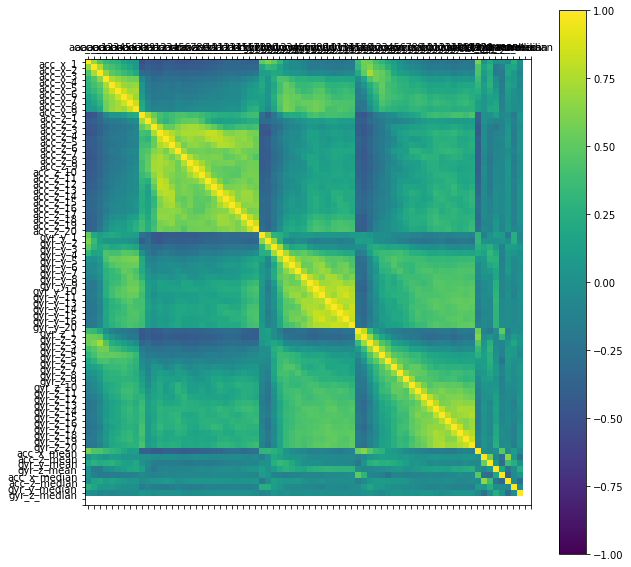

In [17]:
correlations = features.iloc[:, 2:].corr()

# plot correlation matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(features.iloc[0]),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(features.iloc[:, 2:].columns)
ax.set_yticklabels(features.iloc[:, 2:].columns)
plt.show()

## Data Partitioning

In [18]:
X = features.iloc[:,2:].values
y = features.iloc[:, 1].values

# Splitting the dataset into the Training set and Test set (dependent)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

## Data Partitioning (OneClass-SVM) 

In [67]:
import random

def random_data_row():
    upper_bound = data.shape[0]
    return random.randint(0, upper_bound - 1)

def generate_invalid_gesture(batch_size):
    # We take 5 following feature values from existing gestures
    # And add them to the new gesture
    new_row = {}
    
    source_row_nr = random_data_row()
    n = 0
    for col_name in list(data.columns.values):
        if n % batch_size == 0:
            source_row_nr = random_data_row()
        new_row[col_name] = data.loc[source_row_nr, col_name]
        n += 1
    # Make sure the row is marked as invalid gesture
    new_row['IsGesture'] = -1
    return new_row

In [89]:
# Get the features without labels
data = features.iloc[:, 2:]
# Add a "single class" for the one-class SVM 
# Note: All values in the dataset are valid gestures
# and get 1 because of that. None-gesture entries would get -1
data.loc[:, 'IsGesture'] = 1
# Now add generated, invalid gestures as well to have negative examples
data_rows = []
columns = data.columns.values
# Use as much invalid ones as valid ones
for n in range(0, int(data.shape[0] * 0.1)):
    new_row = generate_invalid_gesture(3)
    data_rows.append(new_row.values())
# Create a data frame and merge the two together
generated_data = pd.DataFrame(data_rows, columns=columns)
data = pd.concat([data, generated_data], axis = 0)
# This new label is our single class target
target = data['IsGesture']
# Determine the outlier ratio 
outliers = target[target == -1]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", outliers.shape[0]/target.shape[0])
# Now drop the new column from the data again for unsupervised learning
data.drop(['IsGesture'], axis=1, inplace=True)
# And finally do the train-test split
from sklearn.model_selection import train_test_split  
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8, random_state = 42)  
train_data.shape

outliers.shape (60,)
outlier fraction 0.09090909090909091


/home/rsp/.conda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(528, 73)

In [23]:
# Splitting the dataset into the Training set and Test set (independent)
from sklearn.model_selection import train_test_split

X_train = features_bobs.loc[features["Participant"] != "bobs1", :].iloc[:,2:].values
X_test = features_bobs.loc[features["Participant"] == "bobs1", :].iloc[:,2:].values
y_train = features_bobs.loc[features["Participant"] != "bobs1", :].iloc[:,1].values
y_test = features_bobs.loc[features["Participant"] == "bobs1", :].iloc[:,1].values

NameError: name 'features_bobs' is not defined

KeyError: 'gyr_x_median'

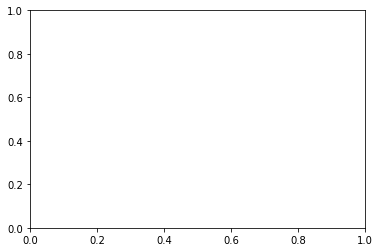

In [21]:
from pandas.plotting import scatter_matrix
from matplotlib.colors import ListedColormap

def plot_scatter(features, gestures, feature):
    ax = plt.subplot(1, 1, 1)
    data = features.loc[(features["Gesture"] == gestures[0]) | (features["Gesture"] == gestures[1]), feature] 
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    classes_scatter=features.loc[(features["Gesture"] == gestures[0]) | (features["Gesture"] == gestures[1]), "Gesture"]
    ax.scatter(data, data, c=classes_scatter, cmap=cm_bright, edgecolors='k')
    
plot_scatter(features, [0,9], 'gyr_x_median')

## Models

### One-Class SVM

In [61]:
import sys
from sklearn import svm

def get_ocsvm(train_data, outliers = np.empty([0])):
    # Measures how many wrong values we expect in the training data
    nu = outliers.shape[0] / target.shape[0]
    # Since 0 is no valid nu value, we use the smallest possible value > 0 instead
    if nu == 0:
        nu = sys.float_info.min
    print("nu", nu)

    model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)  
    model.fit(train_data)  
    return model

### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
    
def get_rf(X_train, y_train):
    # Number of trees in random forest
    n_estimators = np.power(range(1,18),3)
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = np.power(range(1,8),3)
    # Minimum number of samples required to split a node
    #min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    #min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    #bootstrap = [True, False]
    # Create tprint(target)he random grid
    param_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        #'min_samples_split': min_samples_split,
        #'min_samples_leaf': min_samples_leaf,
        #'bootstrap': bootstrap
    }

    #clf_rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
    clf_rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(clf_rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, iid=False)

    grid.fit(X_train, y_train)
    return grid

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer

def get_knn(X_train, y_train):
    # Number of trees in random forest
    n_neighbors = range(1,100)
    param_grid = {
        'n_neighbors': n_neighbors
    }
    
    clf = KNeighborsClassifier(n_neighbors=3)
    kappa_scorer = make_scorer(cohen_kappa_score)
    grid = GridSearchCV(clf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, iid=False)

    grid.fit(X_train, y_train)
    return grid

In [90]:
# One-Class SVM
ocsvm = get_ocsvm(train_data, outliers)
print("OC-SVM: ", ocsvm)

nu 0.09090909090909091
OC-SVM:  OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1, nu=0.09090909090909091, random_state=None,
      shrinking=True, tol=0.001, verbose=False)


In [24]:
# RF
rf = get_rf(X_train, y_train)
print("[INFO] grid search best score: {}".format(rf.best_score_))
print("[INFO] grid search best parameters: {}".format(rf.best_params_))
acc = rf.score(X_test, y_test)
print("[INFO] grid search test accuracy: {:.2f}%".format(acc * 100))

Fitting 3 folds for each of 238 candidates, totalling 714 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 714 out of 714 | elapsed: 24.5min finished


[INFO] grid search best score: 0.9259680476019921
[INFO] grid search best parameters: {'max_depth': 27, 'max_features': 'auto', 'n_estimators': 1000}
[INFO] grid search test accuracy: 96.67%


In [25]:
# KNN
knn = get_knn(X_train, y_train)
print("[INFO] grid search best score: {}".format(knn.best_score_))
print("[INFO] grid search best parameters: {}".format(knn.best_params_))
acc = knn.score(X_test, y_test)
print("[INFO] grid search test accuracy: {:.2f}%".format(acc * 100))

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:    8.7s


[INFO] grid search best score: 0.9330628362682456
[INFO] grid search best parameters: {'n_neighbors': 1}
[INFO] grid search test accuracy: 95.00%


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:   15.5s finished


## Test model

In [91]:
### One-Class SVM
from sklearn import metrics  
preds = ocsvm.predict(train_data)  
targs = train_target

print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))  

accuracy:  0.8806818181818182
precision:  0.9316770186335404
recall:  0.9375
f1:  0.9345794392523364
area under curve (auc):  0.625


In [26]:
from sklearn.metrics import confusion_matrix

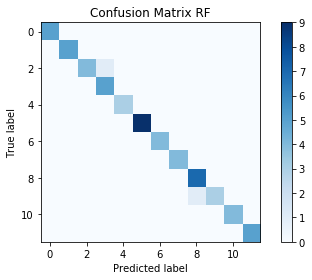

In [27]:
### Random Forest
rf_predicted_y = rf.predict(X_test)
rf_cm = confusion_matrix(y_test, rf_predicted_y)

plt.imshow(rf_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix RF")
plt.colorbar()

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

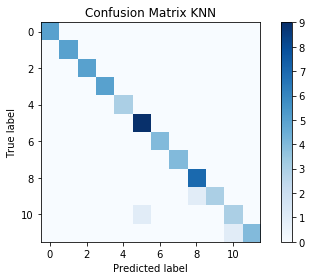

In [28]:
### KNN
knn_predicted_y = knn.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_predicted_y)

plt.imshow(knn_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix KNN")
plt.colorbar()

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Evaluate Model

In [92]:
### One-Class SVM
preds = ocsvm.predict(test_data)  
targs = test_target

print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))

accuracy:  0.8863636363636364
precision:  0.9487179487179487
recall:  0.925
f1:  0.9367088607594937
area under curve (auc):  0.7125


In [29]:
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, precision_score

In [30]:
### Random Forest
print(classification_report(y_test, rf_predicted_y))
print("Accuracy: %.3f" % accuracy_score(y_test, rf_predicted_y))
print("MSE: %.3f" % mean_squared_error(y_test, rf_predicted_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       0.88      1.00      0.93         7
           9       1.00      0.75      0.86         4
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         5

   micro avg       0.97      0.97      0.97        60
   macro avg       0.98      0.96      0.97        60
weighted avg       0.97      0.97      0.97        60

Accuracy: 0.967
MSE: 0.033


In [31]:
### KNN
print(classification_report(y_test, knn_predicted_y))
print("Accuracy: %.3f" % accuracy_score(y_test, knn_predicted_y))
print("MSE: %.3f" % mean_squared_error(y_test, knn_predicted_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3
           5       0.90      1.00      0.95         9
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       0.88      1.00      0.93         7
           9       1.00      0.75      0.86         4
          10       0.75      0.75      0.75         4
          11       1.00      0.80      0.89         5

   micro avg       0.95      0.95      0.95        60
   macro avg       0.96      0.94      0.95        60
weighted avg       0.95      0.95      0.95        60

Accuracy: 0.950
MSE: 0.450


### Save Model

In [32]:
import pickle
filename = 'randomForest.model'
pickle.dump(rf, open(filename, 'wb'))

In [33]:
import coremltools
coreml_model = coremltools.converters.sklearn.convert(rf)
coreml_model.save('RandomForest.mlmodel')

ModuleNotFoundError: No module named 'coremltools'